In [ ]:
from IPython.display import Image, display
Image("ryoko.png", width="70")

# Message from Dr. Ryoko
"*Hi! I hope you now understand how the Lights Out puzzle works.<br/>The floor of the room I must cross has 3 x 3 tiles. Each tile is made of a single qubit.<br/>
Some of these qubits fluctuate between the ground state and the excited state. <br/> I have been observing their behavior and noticed that there is a pattern - the floor can only be in either one of the four patterns as shown in each of the examples below. <br/>
Due to decoherence, there is not enough time to play around with the switches.<br/> You need to find out which board can be cleared with three switch operations. Good luck!*"<br/>

# Week2-B: Four-Lights Out
In this problem, we are dealing with multiple binary data at the same time. 
We have to determine if each of the given four Lights Out boards are solvable under the given constraints, so let's devise a quantum circuit to solve them all at the same time.

As an example, let's consider how to find a board that can be cleared with just a single switch operation from the 4 boards given below. The initial state of the 4 boards is given in the following two-dimensional array, where "0" and "1" represent "off" and "on" respectively similar to the previous learning problem:

lightsout4_ex=\[\[Board 0\],\[Board 1\],\[Board 2\],\[Board 3\]\]

In [ ]:
from IPython.display import Image, display
Image('4lightsout_ex.png')

## Answer Strategy
If only one board is given, this is a decision problem.
Using the algorithm from the first Lights Out puzzle (2A), you can solve this problem by counting the "1"s in the output.
 
If we are given multiple boards, there will be several approaches.
1. Iterate the same "one board algorithm" for each board.
2. Hold information for multiple boards at the same time and solve the problems in a single run (execute the algorithm once). 
- For the rest of this document, we discuss how to use the latter approach to solve this type of problem.

First, how do we keep data for all the boards at the same time?
1. Naive data structures:　　9 Qubits/board * 4 boards > 32 qubits (Upper limit of ibm_qasm_simulator).
2. Prepare the  superposition state:   $\vert Board 0\rangle + \vert Board 1\rangle + \vert Board 2\rangle + \vert Board 3\rangle$.
    - The circuit configuration used for state generation is non-trivial.
3. *qRAM* is known as one solution. 
    - **Pros**: Intuitive implementation. 
    - **Cons**: Computationally expensive. 

Of course you can devise and adopt other smart ways to do this.

Here, we will focus on *qRAM* and describe its configuration and implementation.

In [ ]:
from qiskit import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
provider = IBMQ.load_account()

## qRAM: Quantum Random Access Memory

In classical computers, RAM (Random Access Memory) is a type of volatile memory that has memory addresses $j$ and stores binary data corresponding to each address $D_j$.

In the case of [qRAM](https://arxiv.org/abs/0708.1879) in a quantum computer, **address qubits $a$** have the $N$-addresses as superposition and the corresponding binary data is stored in **data qubits $d$** as a state vector.
\\[
\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert 0 \rangle_{d}\xrightarrow{qRAM}\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert D_{j} \rangle_{d}
\\]　　
We call the right-hand side state "qRAM" and the corresponding gate operation "qRAM operation".

Although qRAM operation requires $\mathcal{O}(N\log N)$ gates, it can be used to create superposition states of binary data intuitively.  

qRAM has previously been applied to various quantum machine learning algorithms such as the HHL algorithm. For this problem, let's apply qRAM to Grover's algorithm.

## Example: Find the data from qRAM
Prepare a qRAM of $n$-addresses in which the numbers $k_0, k_1, .. , k_{n-1}$ are stored in this order.  
Find the address in which the number $m$ is stored using Grover's algorithm.  
- $n = 4$
- $k = [1,2,5,7]$
- $m = 7$

### qRAM operation.
Here we show a circuit example of qRAM.

In [ ]:
address = QuantumRegister(2,name="add")
data = QuantumRegister(3,name="data")
oracle = QuantumRegister(1,name="o")
ancilla = QuantumRegister(1,name="ancilla")
c = ClassicalRegister(2)
qc = QuantumCircuit(address,data,oracle,ancilla,c)

# address preparation
qc.h([address[0],address[1]])
qc.barrier()
# prepare oracle
qc.x(oracle[0])

"""QRAM"""
def prepare_addresses():
    # address 0 -> data = 2
    qc.x([address[0],address[1]])
    qc.ccx(address[0],address[1],data[1])
    qc.x([address[0],address[1]])
    qc.barrier()
    # address 1 -> data = 7
    qc.x(address[0])
    qc.ccx(address[0],address[1],data[2])
    qc.ccx(address[0],address[1],data[1])
    qc.ccx(address[0],address[1],data[0])
    qc.x(address[0])
    qc.barrier()
    # address 2 -> data = 1
    qc.x(address[1])
    qc.ccx(address[0],address[1],data[2])
    qc.x(address[1])
    qc.barrier()
    # address 3 -> data = 5
    qc.ccx(address[0],address[1],data[2])
    qc.ccx(address[0],address[1],data[0])
    qc.barrier()

def diffuse():
    # Apply transformation |s> -> |00..0> (H-gates)
    qc.h(address)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    qc.x(address)
    # Do multi-controlled-Z gate
    qc.h(address[-1])
    qc.mct(address[:-1], address[-1], ancilla, mode="basic")  # multi-controlled-toffoli
    qc.h(address[-1])
    # Apply transformation |11..1> -> |00..0>
    qc.x(address)
    # Apply transformation |00..0> -> |s>
    qc.h(address)

# init qram
prepare_addresses()
# mark the state m
qc.h(oracle[0])
qc.mct(data, oracle, ancilla, mode="basic")
qc.h(oracle[0])
# undo the qram
prepare_addresses()
# diffuse
diffuse()

#Check the result
qc.measure(address[0:2], c[0:2])
 
# Reverse the output string.
# address[0] is measured in c0, so it's the LSB
# with reverse, it ends up in the right as expected (where the LSB should be)
qc = qc.reverse_bits()

#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
#job = execute(qc, backend=backend, shots=8192)
result = job.result()
count =result.get_counts()
print(count)

qc.draw(output='mpl')

### qRAM Data Search
To perform Grover's algorithm, we invert the sign of the **address qubit** containing $m$. We also need to initialize the **data qubit** by another qRAM operation before the Diffusion operation,

\begin{align*}
\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f}
\xrightarrow{oracle}  
\left \{
 \begin{array}{l}
-\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f},  D_{j} = m\\
\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f},  D_{j}  \neq m
 \end{array}
 \right.
 \xrightarrow{qRAM}
\left \{
 \begin{array}{l}
-\vert j \rangle_{a}\vert 0 \rangle_{d}\vert - \rangle_{f},  D_{j} = m \\
\vert j \rangle_{a}\vert 0 \rangle_{d}\vert - \rangle_{f},　D_{j}\neq m
 \end{array}
 \right.
 \end{align*}
 
where $f$ denotes the flag qubit.  

In this case, we can configure an oracle operation using the [C3X gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.C3XGate.html#qiskit.circuit.library.C3XGate) . 

Here, we show the whole circuit for our [qRAM example](#qRAM-Example:-Find-the-data-from-qRAM).

In [ ]:
Image('circuit_ex.png')

### Considerations for qRAM implementation
In the above description we have introduced a naive *qRAM operation* circuit.
Depending on the data structure, we can simplify the circuit by using **gate synthesis** (equivalence transformation) techniques.
Also, some simplified gates, e.g. [RCCX](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RCCXGate.html#qiskit.circuit.library.RCCXGate), may help improve your *CNOT*-saving implementation.

An example of gate synthesis is shown below.

In [ ]:
Image('gatesynthesis_ex.png')

## Learning Exercise II-B
Let's solve a 4-Lights Out problem with qRAM.  

When the initial board state lightsout4=\[\[Board 0\],\[Board 1\],\[Board 2\],\[Board 3\]\] is described by the following data, 
determine the _binary_ number of the solvable boards in $3$ switch operations.  (ex. Board 0 → 00, 1 → 01, 2 → 10, 3 → 11)

Answer by creating a quantum circuit to solve the puzzle shown in the figure below. In the quantum circuit to be submitted, measure only the `solution` (2bit) that solves the puzzle.

To submit your solution, create a function which takes "lightsout4" as an input and returns `QuantumCircuit`.  You can choose a function name you like. Make sure it works even if you input another dataset to "lightsout4".

 **In addition, please implement the quantum circuit within 28 qubits.**

Please note that you can get the answer with the same endian as the one used in the description. You can also use the following function.
```python
qc = qc.reverse_bits()
```

In [ ]:
Image('4lightsout_pr.png')

In [ ]:
lightsout4=[[1, 1, 1, 0, 0, 0, 1, 0, 0],[1, 0, 1, 0, 0, 0, 1, 1, 0],[1, 0, 1, 1, 1, 1, 0, 0, 1],[1, 0, 0, 0, 0, 0, 1, 0, 0]]

### Hints
- Change the oracle of [qRAM data search](#qRAM-Data-search) to an appropriate one.
- Data storing/writing in *QRAM operation* can be performed in any order. We can reduce the number of gates by taking into account the _hamming distance_ of the address and input data.

In [1]:
# Common Helpers
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

def gatifier(circuit):
    """
    Builds a gate compatible circuit unrolling the input into u3,cx

    Args
    --------------------
    circuit: circuit to turn into a gate
    """
    # Build a new compatible circuit
    from qiskit.transpiler import PassManager
    from qiskit.transpiler.passes import Unroller
    pass_ = Unroller(['u3', 'cx'])
    pm = PassManager(pass_)
    gate_circuit = pm.run(circuit)
    # turn the new circuit into a gate
    gate_circuit.to_gate()
    return gate_circuit

def diffuser(qbits, ancilla_amount=0):
    """
    Creates a gate that performs a diffusion algorithm to the given qubits.
    The input is expected as: 9 qubits to diffuse, ancilla_amount qubits

    Args
    --------------------
    qbits: the amount of qbits to diffuse
    ancilla_amount: the amount of ancilla qubits to use by the MCT with mode=basic
    """
    qc = QuantumCircuit(qbits + ancilla_amount, name="diffuser")
    qlist = [i for i in range(0,qbits)]
    ancilla = [i for i in range(qbits, qbits+ancilla_amount)]
    # Apply transformation |s> -> |00..0> (H-gates)
    qc.h(qlist)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    qc.x(qlist)
    # Do multi-controlled-Z gate
    qc.h(qlist[-1])
    if ancilla_amount > 0:
        qc.mct(qlist[:-1], qlist[-1], ancilla, mode="basic")  # multi-controlled-toffoli
    else:
        qc.mct(qlist[:-1], qlist[-1])
    qc.h(qlist[-1])
    # Apply transformation |11..1> -> |00..0>
    qc.x(qlist)
    # Apply transformation |00..0> -> |s>
    qc.h(qlist)
    qc.to_gate()
    return qc

In [2]:
# Helper from 2a

def lights_out_player():
    """
    Creates a gate that applies 9 bit operations to 9 bit boards.
    Qubits are expected as: 9 operations, 9 board
    """
    from qiskit.circuit.library import CXGate
    # 9 operations, 9 board
    qc = QuantumCircuit(9+9, name="player")
    # apply operations to the board
    qc.mcmt(CXGate(),0,[9,10,12]) #0,1,3
    qc.mcmt(CXGate(),1,[9,10,11,13]) #0,1,2,4
    qc.mcmt(CXGate(),2,[10,11,14])#1,2,5
    qc.mcmt(CXGate(),3,[9,12,13,15])#0,3,4,6
    qc.mcmt(CXGate(),4,[10,12,13,14,16])#1,3,4,5,7
    qc.mcmt(CXGate(),5,[11,13,14,17])#2,4,5,8
    qc.mcmt(CXGate(),6,[12,15,16])#3,6,7
    qc.mcmt(CXGate(),7,[13,15,16,17])#4,6,7,8
    qc.mcmt(CXGate(),8,[14,16,17])#5,7,8
    # Return a new compatible circuit
    return gatifier(qc)

def week2a(iterations=17, ancilla_amount=0, as_gate=True):
    """
    Create a circuit/gate that given a set of operations and a board, amplifies
    the probability of the state (pair board+operation) that is a solution.
    Qubits are expected as:
        * 9 operations = mustcontain the possible operations to apply to the board
        * 9 board = the initialized borads. This has to turn |0> for the operation to be the solution
        * 1 oracle = oracle to flip the phase. It must be received  in |0>
        * ancilla_amount qubits = the ancilla qubits to use
    Args
    --------------------
    iterations: the amount of iterations to perform with Grover's. 17 is the ideal
    as_gate: True if the circuit should be returned as a gate, False if not
    ancilla_amount: the amount of ancilla qubits to use
    """
    # registers DB
    operations = [i for i in range(0,9)]
    board = [i for i in range(9,18)]
    oracle = [18]
    ancilla = [i for i in range(19,19+ancilla_amount)]
    qc = QuantumCircuit(
        QuantumRegister(9,name="ops"),
        QuantumRegister(9,name="board"),
        QuantumRegister(1,name="ora"), name="U_2A")
    # use ancilla bits if requred
    if ancilla_amount > 0:
        qc.add_register(QuantumRegister(ancilla_amount,name="ancilla"))

    # init oracle in state |1> 
    qc.x(oracle[0])

    # Grovers Algorithm
    # Ideal iterations is 17
    for j in range(iterations):
        """ ORACLE """
        # Mark the correct state
        qc.append(lights_out_player(), operations+board)
        # Use the oracle to flip board 000000000
        qc.x(board)
        qc.h(oracle)
        if ancilla_amount > 0:
            qc.mct(board, oracle, ancilla, mode="basic")
        else:
            qc.mct(board, oracle)
        qc.h(oracle)
        qc.x(board)
        # restore auxiliary qubits with uncomputation
        qc.append(lights_out_player(), operations+board)

        """ DIFFUSER """
        if ancilla_amount > 0:
            qc.append( diffuser(9, ancilla_amount), operations + ancilla)
        else:
            qc.append( diffuser(9), operations)

    # turn into a gate
    return gatifier(qc) if as_gate else qc

In [3]:
# Helpers for 2b

def one_counter():
    """
    Counts the amount of ones in a 9 qubit register.
    Qubits are expected as: 9 input, 4 output, 2 ancilla.
    The result is in the shape:
        count[4] ... count[0]
          LSB    ...   MSB
    i.e. 4 = '0010'
    """
    qc = QuantumCircuit(9+4+2,name="counter")
    # create dbs
    q = [0,1,2,3,4,5,6,7,8]
    count = [9,10,11,12]
    ancilla = [13,14]
    for i in range(9):
        qc.mct([q[i],count[1],count[2],count[3]],count[0], ancilla, mode="basic")
        qc.mct([q[i],count[2],count[3]],count[1], ancilla[0], mode="basic")
        qc.ccx(q[i],count[3],count[2])
        qc.cx(q[i],count[3])
    qc.to_gate()
    return qc

def set_boards(state0):
    """
    Assigns 4 boards in state0 to registers matching their address.
    state[0] is assigned to address 0, state[1] to address 1, etc.
    Qubits are expected as: 2 address, 9 board

    Args
    --------------------
    state0: list with 4 states. Each state is a least of 9 bits.
    """
    def set_state(circuit, state, address, board):
        # init board
        for i,x in enumerate(state):
            if x:
                circuit.ccx(address[0],address[1],board[i])
    qc = QuantumCircuit(2+9, name="init_boards")
    address = [0,1]
    board = [2,3,4,5,6,7,8,9,10]
    # init all boards in the respective addresses:
    # address 0 -> board = state0[0]
    qc.x([address[0],address[1]])
    set_state(qc, state0[0], address, board)
    qc.x([address[0],address[1]])
    # address 1 -> board = state0[1]
    qc.x(address[0])
    set_state(qc, state0[1], address, board)
    qc.x(address[0])
    # address 2 -> board = state0[2]
    qc.x(address[1])
    set_state(qc, state0[2], address, board)
    qc.x(address[1])
    # address 3 -> board = state0[3]
    set_state(qc, state0[3], address, board)
    qc.to_gate()
    return qc

In [11]:
def week2b_ans_func(lightout4, reverse=True):
    # the db is as follows:
    address = [0,1]
    oracle = [2]
    board = [3,4,5,6,7,8,9,10,11]
    operations = [12,13,14,15,16,17,18,19,20]
    count = [21,22,23,24]
    oracle_2a = [25]
    # remaining
    rest = [26,27]
    # classical_amount = 2+4+9+9
    classical_amount=2
    qc = QuantumCircuit(
        QuantumRegister(2,name="address"),
        QuantumRegister(1,name="oracle"),
        QuantumRegister(9,name="board"),
        QuantumRegister(9,name="ops"),
        QuantumRegister(4,name="count"),
        QuantumRegister(1,name="oracle_2a"),
        QuantumRegister(2,name="anc"),
        ClassicalRegister(classical_amount))

    # prepare addresses and oracle
    qc.h(address)

    """ Init QRAM """
    # assign a board to each address
    qc.append( set_boards(lightout4), address + board )
    # load all operations
    qc.h(operations)

    """ Apply U_2A to find the solution to each board """
    # ancilla = count + oracle + rest
    qc.append(week2a(as_gate=True, ancilla_amount=7), operations+board+oracle_2a + count+oracle+rest)

    """ 2B ORACLE """
    # Count the amount of ones in each operation. ancilla = count+rest
    qc.append(one_counter(), operations + count + rest)
    # flip the phase
    qc.x([ count[0], count[1] ])
    qc.x(oracle)
    qc.h(oracle[0])
    qc.mct(count, oracle[0], rest, mode="basic")
    qc.h(oracle[0])
    qc.x(oracle)
    qc.x([ count[0], count[1] ])
    # undo count
    qc.append(one_counter().inverse(), operations + count + rest)


    """ Undo U_2A """
    qc.append(week2a(as_gate=True, ancilla_amount=7).inverse(), operations+board+oracle_2a + count+oracle+rest)

    # """ Undo QRAM """
    qc.append( set_boards(lightout4).inverse(), address + board )

    # # diffuse
    qc.append(diffuser(2), address)


    # measure addresses
    # qc.measure(board + operations + count + oracle + address, [i for i in range(classical_amount)])
    # qc.measure(board + operations + count + address, [i for i in range(classical_amount)])
    qc.measure(address, [0,1])
     
    # Reverse the output string.
    qc = qc.reverse_bits() if reverse else qc
    return qc

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The multi-control multi-target gate has moved to the circuit library as of 0.14.0 and will not be useable as circuit method anymore. This method will be removed no earlier than 3 months after the release date. You should create the qiskit.circuit.library.MCMT or MCMTVChain circuits and add then to your circuit using append, extend, or compose.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The multi-control multi-target gate has moved to the circuit library as of 0.14.0 and will not be useable as circuit method anymore. This method will be removed no earlier than 3 months after the release date. You should create the qiskit.circuit.library.MCMT or MCMTVChain circuits and add then to your circuit using append, extend, or compose.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The multi-c

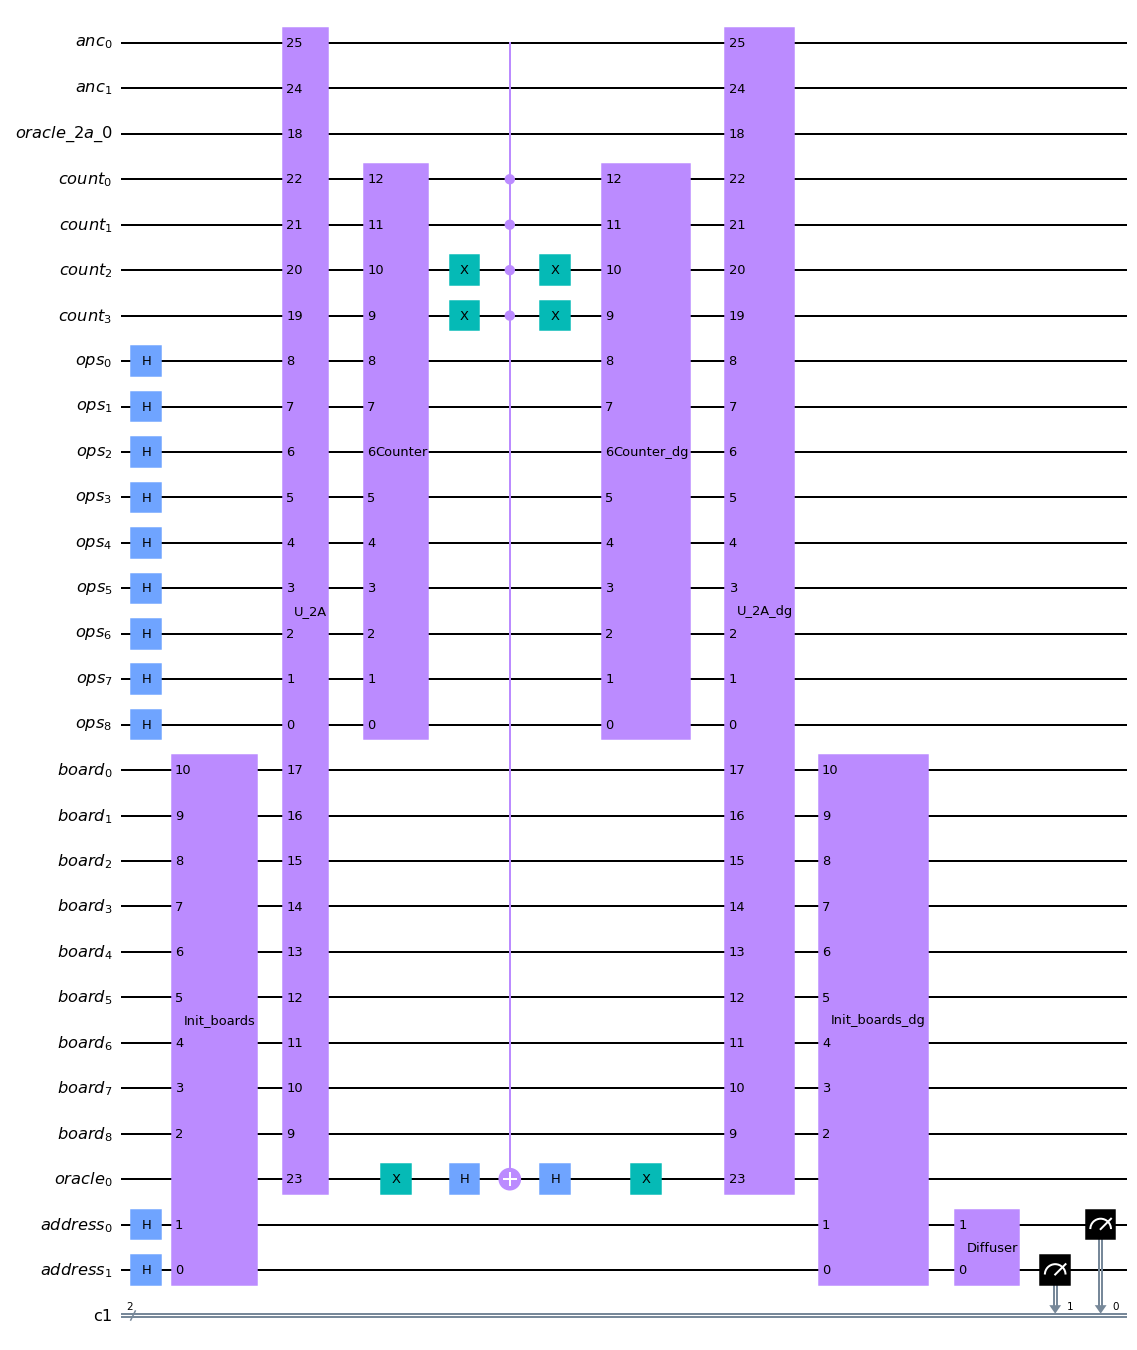

In [12]:
lightsout4=[[1, 1, 1, 0, 0, 0, 1, 0, 0],[1, 0, 1, 0, 0, 0, 1, 1, 0],[1, 0, 1, 1, 1, 1, 0, 0, 1],[1, 0, 0, 0, 0, 0, 1, 0, 0]]
qc = week2b_ans_func(lightsout4)
qc.draw(output='mpl')

In [13]:
from qiskit import IBMQ, Aer, execute
provider = IBMQ.load_account()

backend = Aer.get_backend('qasm_simulator')
lightsout4=[[1, 1, 1, 0, 0, 0, 1, 0, 0],[1, 0, 1, 0, 0, 0, 1, 1, 0],[1, 0, 1, 1, 1, 1, 0, 0, 1],[1, 0, 0, 0, 0, 0, 1, 0, 0]]
qc = week2b_ans_func(lightsout4)
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
#job = execute(qc, backend=backend, shots=8192)
result = job.result()
count =result.get_counts()
print(count)

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The multi-control multi-target gate has moved to the circuit library as of 0.14.0 and will not be useable as circuit method anymore. This method will be removed no earlier than 3 months after the release date. You should create the qiskit.circuit.library.MCMT or MCMTVChain circuits and add then to your circuit using append, extend, or compose.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The multi-control multi-target gate has moved to the circuit library as of 0.14.0 and will not be useable as circuit method anymore. This method will be removed no earlier than 3 mont

{'01': 8000}


In [14]:
# Submission code
from qc_grader import prepare_ex2b, grade_ex2b, submit_ex2b

# Execute your circuit with following prepare_ex2b() function.
# The prepare_ex2b() function works like the execute() function with only QuantumCircuit as an argument.
job  =  prepare_ex2b(week2b_ans_func)

result = job.result()
count = result.get_counts()
original_problem_set_counts = count[0]

original_problem_set_counts
# The bit string with the highest number of observations is treated as the solution.

Running week2b_ans_func...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The multi-control multi-target gate has moved to the circuit library as of 0.14.0 and will not be useable as circuit method anymore. This method will be removed no earlier than 3 months after the release date. You should create the qiskit.circuit.library.MCMT or MCMTVChain circuits and add then to your circuit using append, extend, or compose.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The multi-control multi-target gate has moved to the circuit library as of 0.14.0 and will not be useable as circuit method anymore. This method will be removed no earlier than 3 months after the release date. You should create the qiskit.circuit.library.MCMT or MCMTVChain circuits and add then to your circuit using append, extend, or compose.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The multi-c

Computing cost...
Starting experiments. Please wait...
You may monitor the job (id: 5fb893a5d721ea0019ea84c9) status and proceed to grading when it successfully completes.


{'01': 8000}

In [15]:
# Check your answer by executing following code.
# The quantum cost of the QuantumCircuit is obtained as the score. The quantum cost is related to rank only in the third week.
grade_ex2b(job)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.
Your score is 77608.
Feel free to submit your answer.


In [16]:
# Submit your results by executing following code. You can submit as many times as you like during the period. 
submit_ex2b(job)

Submitting your answer. Please wait...

Success 🎉! Your answer has been submitted.
There seems to be huge "noise clusters" interfering with Dr. Ryoko’s device. Can you please help?


In [14]:
# get results from previous jobs
job_id = "5fb7e3555c506f001cc483b6"
# load backend where the job was run
from qiskit import IBMQ
backend = IBMQ.load_account().get_backend('ibmq_qasm_simulator')
job = backend.retrieve_job(job_id)
# load result
result = job.result()
count = result.get_counts()
print(count)

ibmqfactory.load_account:WARNING:2020-11-20 17:09:10,275: Credentials are already in use. The existing account in the session will be replaced.


[{'01': 8000}, {'00': 7995, '10': 3, '11': 2}]
